### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [1]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [2]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [3]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
# Load in the feature summary file.
feat_info =  pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
def string_to_int(string):
    try:
        return int(string)
    except ValueError:
        return string

feat_info['NA_values'] = feat_info['missing_or_unknown'].apply(string_to_int)

feat_info.head()

,attribute,information_level,type,missing_or_unknown,NA_values
0,AGER_TYP,person,categorical,"[-1,0]","[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [9]:
# Identify missing or unknown data values and convert them to NaNs.

for i, (column, values) in enumerate(azdias.iteritems()):
    NaN_values = feat_info.loc[feat_info['attribute'] == column, 'missing_or_unknown'].values[0]
    NaN_values = NaN_values[1:-1].split(',')
    
    if NaN_values != ['']:
        empty_list = []
        for x in NaN_values:
            if x in ['X', 'XX']:
                empty_list.append(x)
            else:
                empty_list.append(int(x))
        azdias[column] = azdias[column].replace(empty_list, np.nan)

print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
missing_counts = azdias.isna().sum()
print(missing_counts)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_percentages = (azdias.isna().sum() / len(azdias)) * 100
print(missing_percentages)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [12]:
# Investigate patterns in the amount of missing data in each column.

missing_percentages = (azdias.isna().sum() / len(azdias)) * 100
missing_percentages_sorted = missing_percentages.sort_values(ascending=False)
#sorted percentages in ascending order
print(missing_percentages_sorted)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

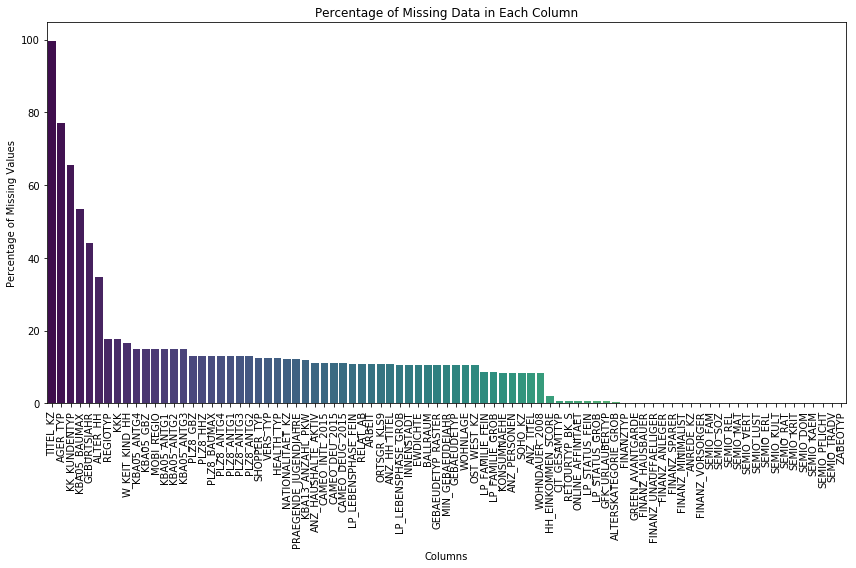

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_percentages_sorted.index, y=missing_percentages_sorted.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Data in Each Column')
plt.tight_layout()
plt.show()

In [14]:
print(azdias.columns)

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


# List of columns to remove
col_to_remove = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

# Drop columns from azdias
existing_columns = [col for col in col_to_remove if col in azdias.columns]
azdias.drop(existing_columns, axis=1, inplace=True)

# Print remaining columns in azdias after removing
print(azdias.columns)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

There were sixecolumns I decided to remove based on the bar graph above due to them containing more than 20% of missing values. The columns were=

TITEL_KZ
AGER_TYP
KK_KUNDENTYP
KBA05_BAUMAX
GEBURTSJAHR
ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

missing_values = azdias.isnull().sum(axis=1)
missing_values.head(), missing_values.sum()

(0    43
 1     0
 2     0
 3     7
 4     0
 dtype: int64, 5035304)

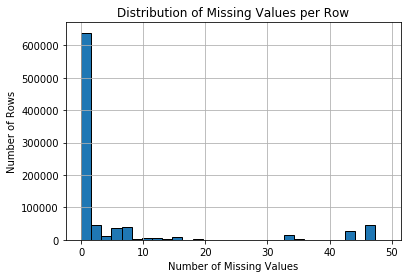

In [17]:
plt.hist(missing_values, bins=30, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.grid(True)
plt.show()

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Picked 25 for threshold based on plot above
threshold = 25

#Split into two subsets based on the threshold
few_missing = azdias[missing_values <= threshold]
many_missing = azdias[missing_values > threshold]

df_few_missing = azdias.iloc[few_missing.index]
df_many_missing = azdias.iloc[many_missing.index]

df_few_missing.shape, df_many_missing.shape

((797961, 79), (93260, 79))

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

non_missing_columns = azdias.columns[azdias.isna().sum() == 0][:5]

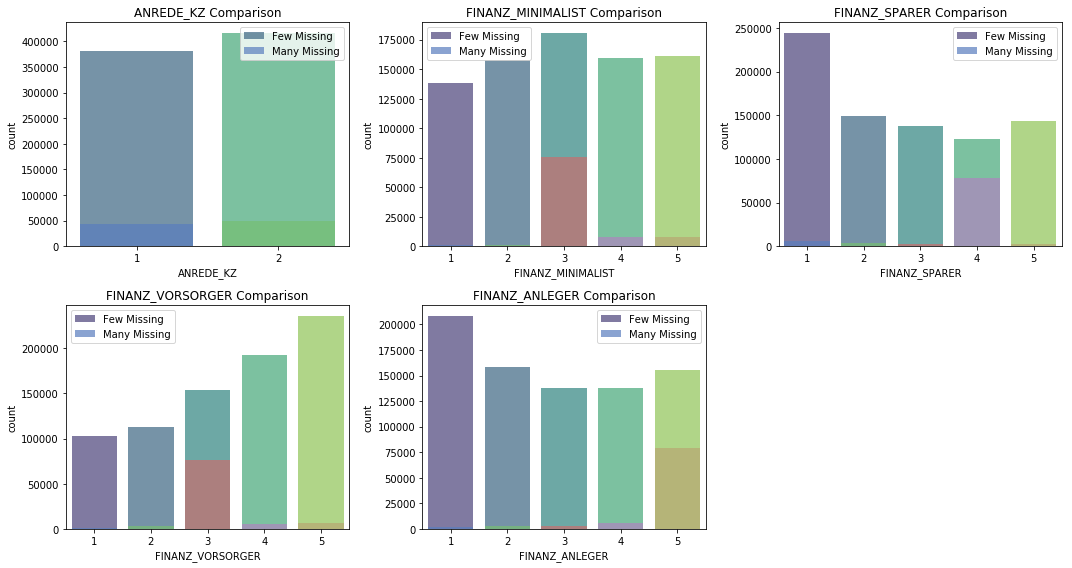

In [20]:
plt.figure(figsize=(15, 8))

for i, column in enumerate(non_missing_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=column, data=df_few_missing, palette='viridis', alpha=0.7, label='Few Missing')
    sns.countplot(x=column, data=df_many_missing, palette='muted', alpha=0.7, label='Many Missing')
    plt.title(f'{column} Comparison')
    plt.legend()

plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the graphs above, there are a few missing values for each.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_feat = feat_info[feat_info.type == 'categorical'].attribute
print(categorical_feat)

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [23]:
categorical_feat = [feat for feat in categorical_feat if feat in azdias]

In [24]:
binary_vars = []
multi_vars = []

for feature in categorical_feat:
    unique_values = set([feature])
    num_unique = len(unique_values)
    
    if num_unique == 2:
        binary_vars.append(feature)
    else:
        multi_vars.append(feature)

print("Binary Variables:", binary_vars)
print("Multi-level Variables:", multi_vars)


Binary Variables: []
Multi-level Variables: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical feature
for feature in categorical_feat:
    azdias[feature] = label_encoder.fit_transform(azdias[feature])


#### Discussion 1.2.1: Re-Encode Categorical Features

I identified the varables and then categorized the categorical variables into binary and multi-level based on the number of unique values each categorical feature has. Next, I label encoded the categorical variables.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_map = {
    1: 1, 2: 1,
    3: 2, 4: 2,
    5: 3, 6: 3,
    7: 4, 8: 4,
    9: 5, 10: 5,
    11: 6, 12: 6
}

movement_map = {
    1: 1, 2: 2,
    3: 1, 4: 2,
    5: 1, 6: 2,
    7: 1, 8: 2,
    9: 1, 10: 2,
    11: 1, 12: 2
}

azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_map)


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [28]:
wealth_map = {
    '11': 1, '12': 1, '13': 1, '14': 1, '15': 1,
    '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
    '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,
    '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
    '51': 5, '52': 5, '53': 5, '54': 5, '55': 5
}

life_stage_map = {
    '11': 1, '12': 2, '13': 3, '14': 4, '15': 5,
    '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
    '31': 1, '32': 2, '33': 3, '34': 4, '35': 5,
    '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
    '51': 1, '52': 2, '53': 3, '54': 4, '55': 5
}

# Create new variables
azdias['Wealth'] = azdias['CAMEO_INTL_2015'].map(wealth_map)
azdias['Life_Stage'] = azdias['CAMEO_INTL_2015'].map(life_stage_map)

print(azdias.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.2.2: Engineer Mixed-Type Features
I added wealth and life stage as the two new variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col_name in azdias.columns:
        na_list = feat_info.loc[feat_info['attribute'] == col_name, 'missing_or_unknown'].iloc[0]
        na_list = na_list.replace('[', '').replace(']', '').split(',')
        if na_list == ['']:
            continue
        else:
            for na_code in na_list:
                if azdias[col_name].dtype == 'object':
                    azdias.loc[azdias[col_name] == na_code, col_name] = np.nan
                else:
                    na_code = int(na_code)
                    azdias.loc[azdias[col_name] == na_code, col_name] = np.nan
    
    
    
  
    
    # Select, re-encode, and engineer column values (add your additional cleaning steps here if any)
    # Example: If you need to re-encode categorical variables, do it here.
    
    # Return the cleaned dataframe
    return azdias


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
print(azdias.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          0              1                  3   
1                   1.0          1              4                  1   
2                   3.0          1              2                  1   
3                   4.0          1              1                  4   
4                   3.0          0              4                  4   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0                 3    

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

cleaned_azdias = (azdias)



In [34]:
print(cleaned_azdias.shape)

(891221, 83)


In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Removal of rows with any missing values
cleaned_azdias.dropna(inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_azdias)

In [36]:
# Apply feature scaling to the general population demographics data.

scaled_azdias = pd.DataFrame(scaled_features, columns=azdias.columns)


### Discussion 2.1: Apply Feature Scaling

I applied feature scaling using the StandardScaler after cleaning and handling missing values. This ensures that the demographics data is prepared for dimensionality reduction techniques and other machine learning applications, which will lead to more robust and interpretable analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

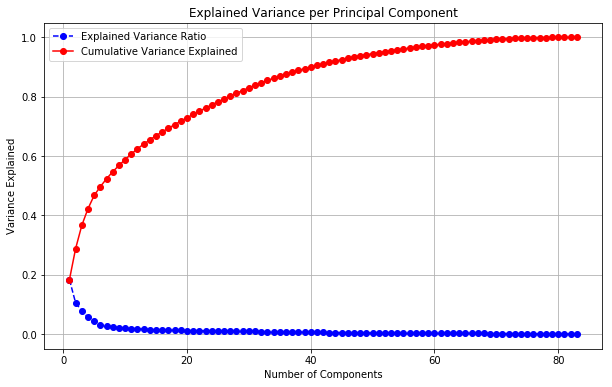

In [37]:
# Apply PCA to the data.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_features)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio and cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance per Principal Component')
plt.legend()
plt.grid(True)
plt.show()



In [38]:
# Investigate the variance accounted for by each principal component.

explained_variance_ratio = pca.explained_variance_ratio_

for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio:.4f}")

Principal Component 1: 0.1833
Principal Component 2: 0.1048
Principal Component 3: 0.0783
Principal Component 4: 0.0563
Principal Component 5: 0.0446
Principal Component 6: 0.0298
Principal Component 7: 0.0266
Principal Component 8: 0.0236
Principal Component 9: 0.0210
Principal Component 10: 0.0201
Principal Component 11: 0.0184
Principal Component 12: 0.0181
Principal Component 13: 0.0154
Principal Component 14: 0.0146
Principal Component 15: 0.0140
Principal Component 16: 0.0128
Principal Component 17: 0.0123
Principal Component 18: 0.0120
Principal Component 19: 0.0119
Principal Component 20: 0.0114
Principal Component 21: 0.0112
Principal Component 22: 0.0110
Principal Component 23: 0.0107
Principal Component 24: 0.0106
Principal Component 25: 0.0103
Principal Component 26: 0.0100
Principal Component 27: 0.0096
Principal Component 28: 0.0094
Principal Component 29: 0.0091
Principal Component 30: 0.0090
Principal Component 31: 0.0087
Principal Component 32: 0.0083
Principal Compone

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = np.argmax(cumulative_variance >= 0.95) + 1

pca = PCA(n_components=60)
azdias_pca_transform = pca.fit_transform(scaled_azdias)



### Discussion 2.2: Perform Dimensionality Reduction
I picked 60 components for the analysis in the next step because when n_components is equal to 60, the variance explained is very close to being 90%.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
def component_weights(pca, component_idx, columns):
    # Get the principal component's weights and sort them in descending order
    weights = pca.components_[component_idx]
    sorted_index = weights.argsort()[::-1]
    sorted_weights = weights[sorted_index]
    sorted_features = [columns[i] for i in sorted_index]

    # Print the sorted weights and corresponding features
    for feature, weight in zip(sorted_features, sorted_weights):
        print(f"Feature: {feature}, Weight: {weight}")

columns = azdias.columns

# Assuming pca is already fitted to the scaled features
pca.fit(scaled_features)

# Print weights for the first principal component
component_weights(pca, 0, columns)


Feature: CAMEO_DEU_2015, Weight: 0.20068359585879597
Feature: CAMEO_DEUG_2015, Weight: 0.19871199255556452
Feature: Wealth, Weight: 0.19698580526184684
Feature: CAMEO_INTL_2015, Weight: 0.1943203679950843
Feature: PLZ8_ANTG3, Weight: 0.19306807341886245
Feature: PLZ8_ANTG4, Weight: 0.1860999870197517
Feature: HH_EINKOMMEN_SCORE, Weight: 0.18515209051148307
Feature: PLZ8_BAUMAX, Weight: 0.18196102310072818
Feature: ORTSGR_KLS9, Weight: 0.16047053570390996
Feature: EWDICHTE, Weight: 0.15782870025241172
Feature: FINANZ_HAUSBAUER, Weight: 0.1412191354647476
Feature: KBA05_ANTG4, Weight: 0.13470076904245448
Feature: PLZ8_ANTG2, Weight: 0.13173009559415805
Feature: KBA05_ANTG3, Weight: 0.12367200310300482
Feature: ARBEIT, Weight: 0.12345006968221116
Feature: ANZ_HAUSHALTE_AKTIV, Weight: 0.1201149498350175
Feature: RELAT_AB, Weight: 0.11342619317220769
Feature: ZABEOTYP, Weight: 0.1104331510103358
Feature: FINANZ_SPARER, Weight: 0.08050048720764805
Feature: REGIOTYP, Weight: 0.065662792747186

In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_weights(pca, 1, columns)


Feature: SEMIO_REL, Weight: 0.26966223449128823
Feature: PRAEGENDE_JUGENDJAHRE, Weight: 0.25809976528930817
Feature: Decade, Weight: 0.24945264605280607
Feature: FINANZ_SPARER, Weight: 0.24495833600927824
Feature: SEMIO_PFLICHT, Weight: 0.23900479574813493
Feature: SEMIO_TRADV, Weight: 0.23545439127738657
Feature: SEMIO_KULT, Weight: 0.22717278985253558
Feature: FINANZ_UNAUFFAELLIGER, Weight: 0.18882149548222887
Feature: SEMIO_FAM, Weight: 0.18711962364298892
Feature: SEMIO_RAT, Weight: 0.17665942165828355
Feature: SEMIO_MAT, Weight: 0.17647549510683952
Feature: FINANZ_ANLEGER, Weight: 0.15713474959550447
Feature: Movement, Weight: 0.13798811516395318
Feature: CJT_GESAMTTYP, Weight: 0.12374670961808465
Feature: HEALTH_TYP, Weight: 0.11441541792017364
Feature: ONLINE_AFFINITAET, Weight: 0.10463171178737936
Feature: SEMIO_SOZ, Weight: 0.10294440123329139
Feature: NATIONALITAET_KZ, Weight: 0.0900149345078617
Feature: SEMIO_VERT, Weight: 0.07831089992895475
Feature: ZABEOTYP, Weight: 0.062

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_weights(pca, 2, columns)


Feature: SEMIO_VERT, Weight: 0.3242879601603278
Feature: SEMIO_FAM, Weight: 0.2425223866591308
Feature: SEMIO_KULT, Weight: 0.23790264017225565
Feature: SEMIO_SOZ, Weight: 0.22654181301740617
Feature: FINANZ_MINIMALIST, Weight: 0.15791219602319295
Feature: W_KEIT_KIND_HH, Weight: 0.11841923608043045
Feature: FINANZ_VORSORGER, Weight: 0.11165893395792864
Feature: RETOURTYP_BK_S, Weight: 0.10676325854200559
Feature: SEMIO_REL, Weight: 0.1060357376732045
Feature: ALTERSKATEGORIE_GROB, Weight: 0.09698528879840324
Feature: FINANZTYP, Weight: 0.08424145676457857
Feature: SEMIO_LUST, Weight: 0.07703434140722328
Feature: SEMIO_MAT, Weight: 0.057917253634391694
Feature: VERS_TYP, Weight: 0.040091410970014466
Feature: EWDICHTE, Weight: 0.03612179869904896
Feature: ORTSGR_KLS9, Weight: 0.03522134451543334
Feature: PLZ8_BAUMAX, Weight: 0.03512781634917073
Feature: PLZ8_ANTG3, Weight: 0.03320258639345172
Feature: PLZ8_ANTG4, Weight: 0.032759718903093225
Feature: GREEN_AVANTGARDE, Weight: 0.03203710

### Discussion 2.3: Interpret Principal Components

Positive and negative values provide insights into how features correlate or vary across different dimensions captured by PCA. This understanding helps in finding patterns and relationships within the dataset, which can help with analyses or decision-making processes.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:

from sklearn.decomposition import PCA

# Assuming `scaled_features` is the standardized data
pca = PCA(n_components=10)  # Adjust `n_components` as needed
pca_transformed = pca.fit_transform(scaled_features)  # Apply PCA

# Now proceed with KMeans clustering on the PCA-transformed data
cluster_range = range(2, 31)

# An empty list to store average distances
avg_distances = []
    
for n_clusters in cluster_range:
    # Initialize with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_transformed)
    
    avg_distance = -kmeans.score(pca_transformed)
    avg_distances.append(avg_distance)

# Plot the average distances for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, avg_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance vs. Number of Clusters')
plt.grid(True)
plt.show()

chosen_n_clusters = 10
kmeans = KMeans(n_clusters=chosen_n_clusters, random_state=42)
kmeans.fit(pca_transformed)

# Get cluster assignments for the general demographics data
cluster_assignments = kmeans.predict(pca_transformed)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

a_distances = []

# Iterate over each cluster count
for n_clusters in cluster_range:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    kmeans.fit(pca_transformed)
    
    a_distance = -kmeans.score(pca_transformed)
    a_distances.append(a_distance)

# Plot the average distances for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, a_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance vs. Number of Clusters')
plt.grid(True)
plt.show()


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=chosen_n_clusters, random_state=42)

# Fit KMeans to the transformed data
kmeans.fit(pca_transformed)

# Getting cluster predictions for the data
cluster_predictions = kmeans.predict(pca_transformed)


### Discussion 3.1: Apply Clustering to General Population
I segmented the population into 10 clusters with the goal of uncovering underlying patterns and variations in the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

customers.head()

In [ ]:
non_numeric_columns = customers.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)


for column in non_numeric_columns:
    print(customers[column].unique())  


# Assuming 'W' is a placeholder for a missing value, replace it with NaN
customers.replace('W', np.nan, inplace=True)

# Handle missing values
customers.fillna(customers.mean(), inplace=True)


customers = customers.apply(pd.to_numeric, errors='coerce')


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_scaled = scaler.transform(customers)  # Assuming customer_data is already preprocessed

# 3. PCA Transformation
# Transform the scaled customer data using PCA fitted on general demographics
customer_pca_transformed = pca.transform(customer_scaled)

# 4. Clustering
# Re-fit KMeans model with the selected number of clusters on PCA-transformed customer data
customer_cluster_predictions = kmeans.predict(customer_pca_transformed)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
cluster_counts_general = pd.Series(cluster_predictions_general).value_counts().sort_index()
cluster_proportions_general = cluster_counts_general / len(cluster_predictions_general)


cluster_counts_customer = pd.Series(cluster_predictions_customer).value_counts().sort_index()
cluster_proportions_customer = cluster_counts_customer / len(cluster_predictions_customer)

plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.barplot(x=cluster_proportions_general.index, y=cluster_proportions_general.values, color='blue')
plt.title('Cluster Proportions - General Population')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

# Plot for customer data
plt.subplot(1, 2, 2)
sns.barplot(x=cluster_proportions_customer.index, y=cluster_proportions_customer.values, color='green')
plt.title('Cluster Proportions - Customer Data')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [ ]:
threshold = 1.5  

# Ratios of proportions between customer and general population
cluster_ratios = cluster_proportions_customer / cluster_proportions_general

# Clusters that are overrepresented and underrepresented
overrepresented_clusters = cluster_ratios[cluster_ratios > threshold].index.tolist()
underrepresented_clusters = cluster_ratios[cluster_ratios < (1 / threshold)].index.tolist()

print("Overrepresented clusters:", overrepresented_clusters)
print("Underrepresented clusters:", underrepresented_clusters)

In [ ]:
for cluster in overrepresented_clusters:
    # Get the data points belonging to the overrepresented cluster
    cluster_data = customers_pca[clusters_cust == cluster]

    # Inverse transform to get original feature space
    original_data = scaler.inverse_transform(pca.inverse_transform(cluster_data))

    # Create a DataFrame for the cluster data
    cluster_df = pd.DataFrame(original_data, columns=azdias.columns)

    # Display the summary statistics for the cluster
    print(f"\nSummary statistics for overrepresented cluster {cluster}:")
    print(cluster_df.describe())
    
    # Optionally, display some rows of the cluster data
    print(cluster_df.head())

### Discussion 3.3: Compare Customer Data to Demographics Data



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.